In [1]:
import os
import itertools
import random

import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
%matplotlib inline

random_state = 42

print(np.__version__)
print(sklearn.__version__)

1.24.3
1.2.2


# Training the machine learning models

- Note that the donwloaded files (and created files in this notebook) will be saved in temporary storage on a cloud server.  
If you need to store these files, please download them to your computer via a file browser (folder icon) on the left toolbar.

- The training process of each machine learning models would take a couple of minutes. Please be patient.

In [3]:
# Downloading datasets
save_dir="data/"
if not os.path.exists(save_dir):
      os.makedirs(save_dir)

#!wget -O data/test.csv 'https://www.dropbox.com/s/rl0755n11jum3r3/test.csv?dl=1'
#!wget -O data/train.csv 'https://www.dropbox.com/s/8xjyxub9wavni4v/train.csv?dl=1'

# Preparing datasets
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

y_train_c_sys = train_data['crystal_system']
y_test_c_sys = test_data['crystal_system']
y_train_sgr = train_data['sg_num']
y_test_sgr = test_data['sg_num']

X_train = train_data[[str(i) for i in range(1, 11)] + ['peaknum']]
X_test = test_data[[str(i) for i in range(1, 11)] + ['peaknum']]

classnames = ['Triclinic', 'Monoclinic', 'Orthorhombic', 'Tetragonal', 'Trigonal', 'Hexagonal', 'Cubic']
sgr_nums = np.array(list(set(y_train_sgr)))

In [4]:
# Training crystal system classifier
# This may take couple of minutes.
exrt_crystal_system = ExtraTreesClassifier(n_estimators=500, 
                            max_depth=30, 
                            max_features=9, 
                            n_jobs=-1, 
                            random_state=random_state,
                            warm_start=False)
exrt_crystal_system.fit(X_train, y_train_c_sys)

# validation
y_pred = exrt_crystal_system.predict(X_test)
print('mean accuracy of crystal system prediction: ', metrics.accuracy_score(y_test_c_sys, y_pred)*100)

mean accuracy of crystal system prediction:  92.23539116089259


In [5]:
# Training space group classifier
# This may take couple of minutes.

# To reduce the training time, we set n_estimators=50 which smaller than the article.
# The resulted performance is sligly worse than the original (accuracy 80.46% -> 80.20%).
# If you would like to reproduce the result in the article, please set n_estimators=200.

exrt_sgr = ExtraTreesClassifier(n_estimators=50, n_jobs=-1, max_depth=25, max_features=None, random_state=random_state)
exrt_sgr.fit(X_train, y_train_sgr)

# validation
y_pred = exrt_sgr.predict(X_test)
print('mean accuracy of space group prediction: ', metrics.accuracy_score(y_test_sgr, y_pred)*100)


mean accuracy of space group prediction:  80.20100720673786


In [6]:
# saveing prediction results (if needed)
test_pred = pd.DataFrame()
test_pred['crystal_system_pred'] = exrt_crystal_system.predict(X_test)
test_pred['sg_num_pred'] = exrt_sgr.predict(X_test)
test_pred['sg_num_true'] = test_data['sg_num']
test_pred['crystal_system_true'] = test_data['crystal_system']

test_pred.to_csv('pred_result_test.csv', index=False)

C:\Users\Matsunami\AppData\Local\Temp\ipykernel_6912\1812798883.py:26: RuntimeWarning: invalid value encountered in divide
  cnf_matrix_norm = cnf_matrix / cnf_matrix.sum(axis=1)[:, np.newaxis]


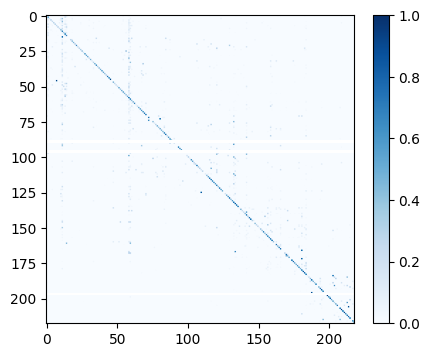

In [7]:
# Plotting a confusion matrix for space group
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix = confusion_matrix(y_test_sgr, y_pred)
cnf_matrix_norm = cnf_matrix / cnf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5,4), dpi=100)
plt.imshow(cnf_matrix_norm, cmap=plt.cm.Blues)
plt.colorbar()

In [8]:
# Miss-prediction analysis: space group 139
u, counts = np.unique(y_pred[y_test_sgr==139], return_counts=True)
print(f'predicted space groups (top5): {u[counts.argsort()[::-1]][:5]}')
print(f'counts: {np.sort(counts)[::-1][:5]}')

predicted space groups (top5): [139 107  87 123 194]
counts: [1496   17   16   14    8]


In [9]:
# Miss-prediction analysis: space group 167
u, counts = np.unique(y_pred[y_test_sgr==167], return_counts=True)
print(f'predicted space groups (top5): {u[counts.argsort()[::-1]][:5]}')
print(f'counts: {np.sort(counts)[::-1][:5]}')

predicted space groups (top5): [167 161  12 136  62]
counts: [585  18  11   6   5]


# Prediction
Here you can predict space group and crystal system using a trained ExtraTreesClassifier.  
If you would predict with your XRD pattern, please provide a list of 10 peak positions from the lowest angle in $Q (Å^{-1})$ as `input_xrd_Q`.  

Example:
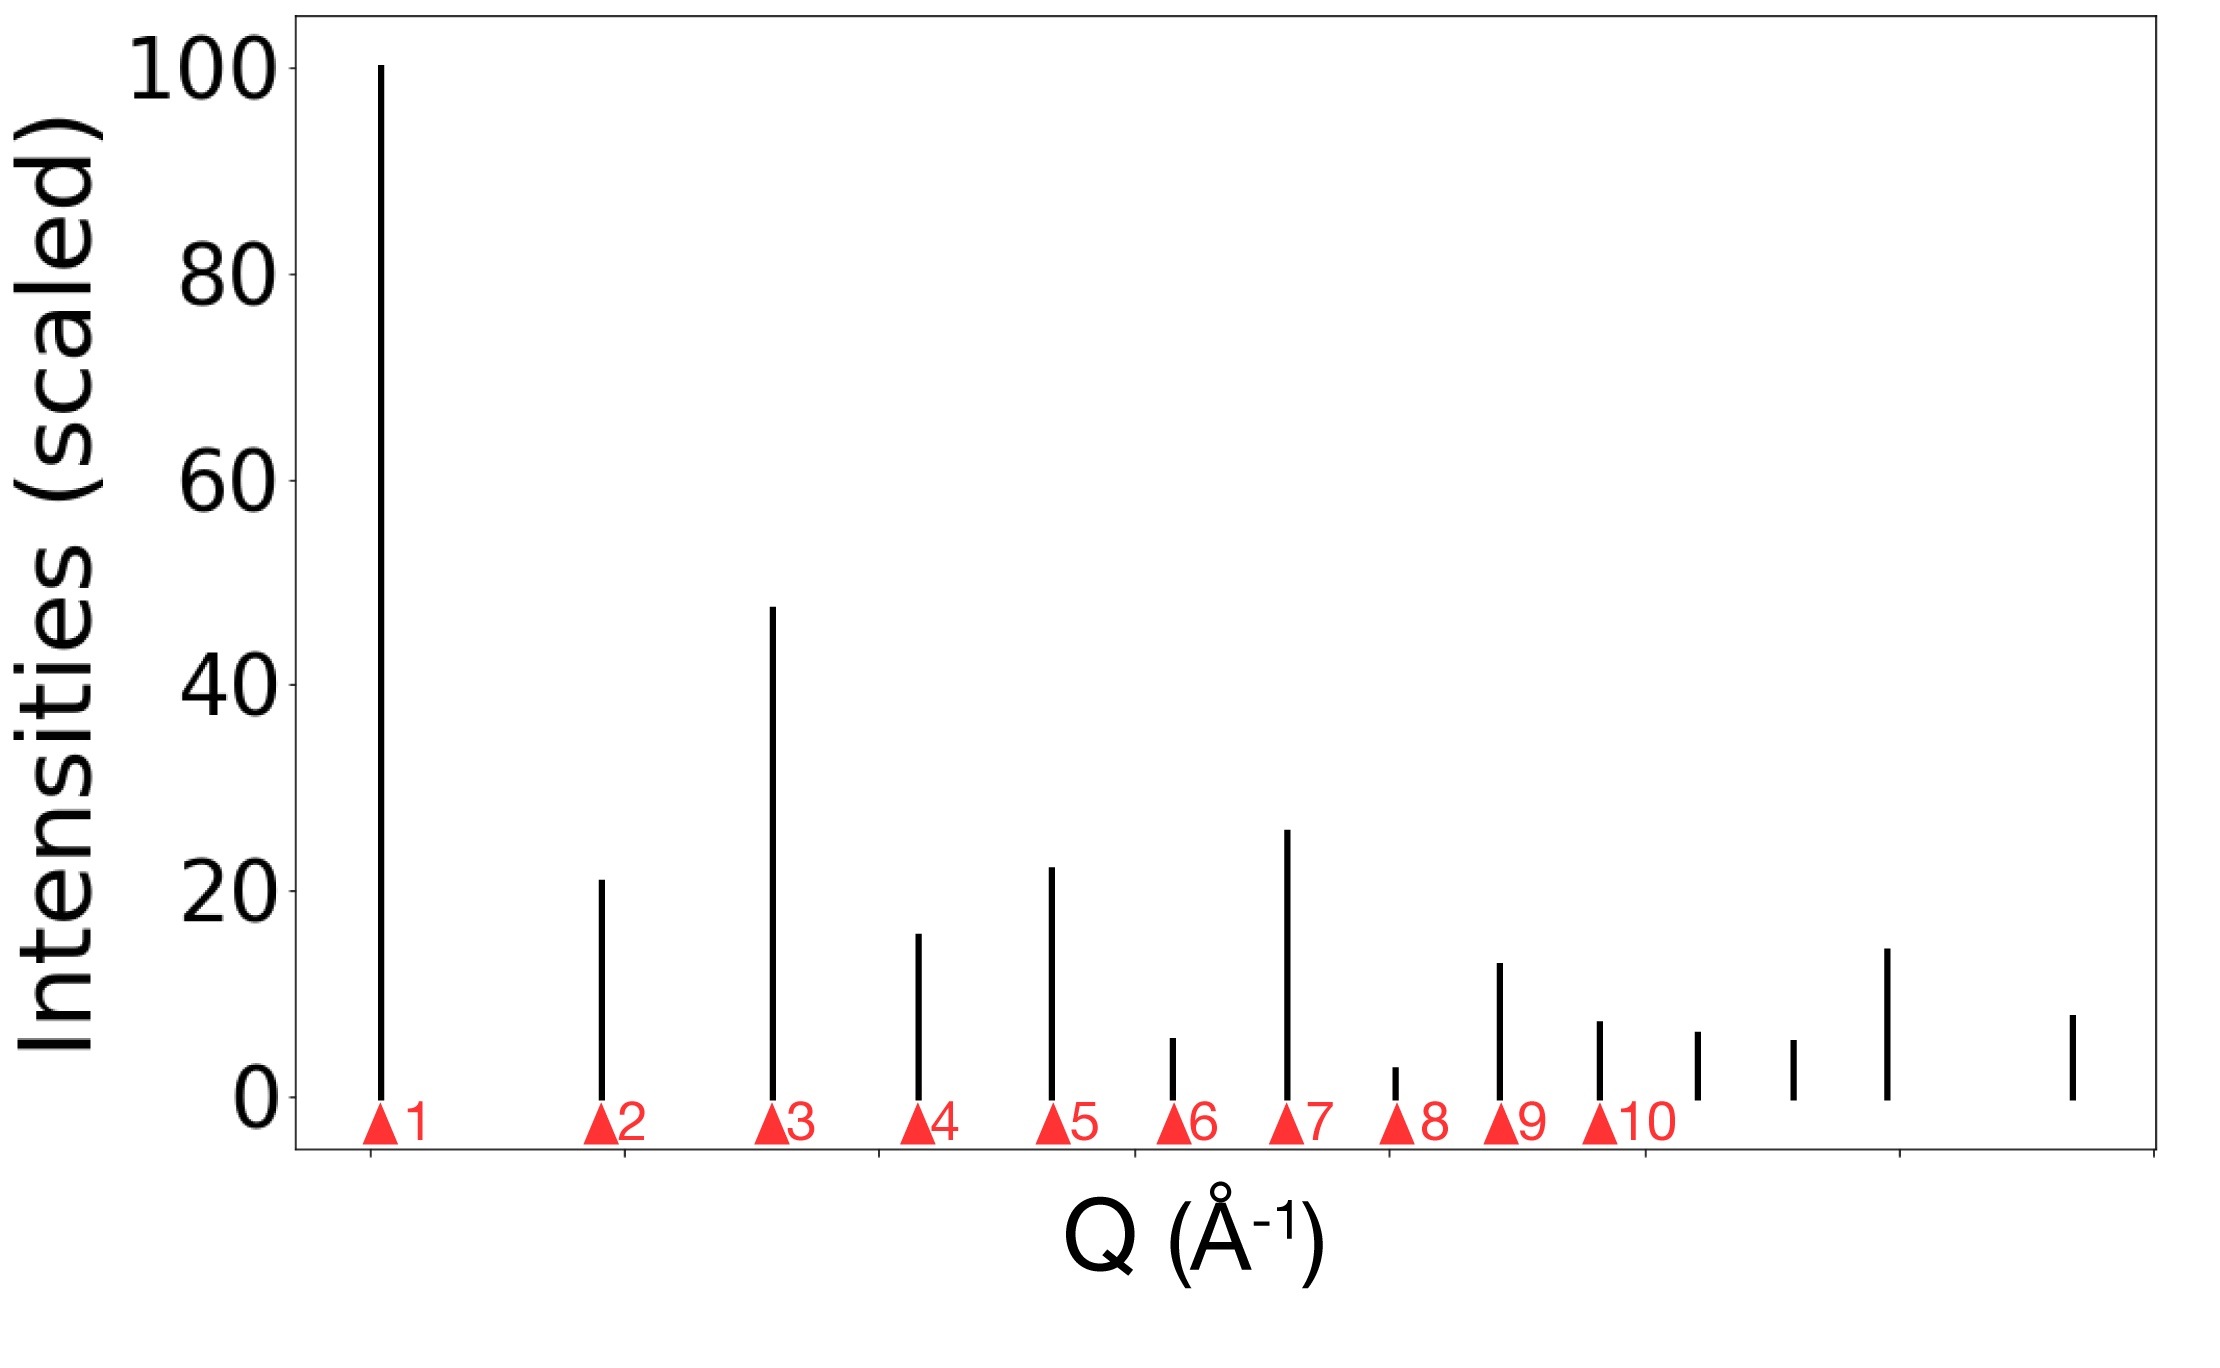

In case of your XRD has less than 10 peaks, please fill with 0, like `[0.81, 0.92, 0.99, 0, 0, 0, 0, 0, 0, 0]`.



In [10]:
# Retraining models to predict without the feature of the number of peaks
# This may take couple of minutes.

X_train = train_data[['q_{}'.format(i) for i in range(1, 11)]]
X_test = test_data[['q_{}'.format(i) for i in range(1, 11)]]

exrt_crystal_system.fit(X_train, y_train_c_sys)
y_pred = exrt_crystal_system.predict(X_test)
print('mean accuracy of crystal system prediction: ', metrics.accuracy_score(y_test_c_sys, y_pred)*100)

exrt_sgr.fit(X_train, y_train_sgr)
y_pred = exrt_sgr.predict(X_test)
print('mean accuracy of space group prediction: ', metrics.accuracy_score(y_test_sgr, y_pred)*100)


mean accuracy of crystal system prediction:  90.17756360163237
mean accuracy of space group prediction:  78.0910827472432


C:\Users\Matsunami\anaconda3\envs\ARIM-v2\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\Matsunami\anaconda3\envs\ARIM-v2\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\Matsunami\anaconda3\envs\ARIM-v2\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


Predicted crystal system:  Orthorhombic
Predicted space group:  [36]


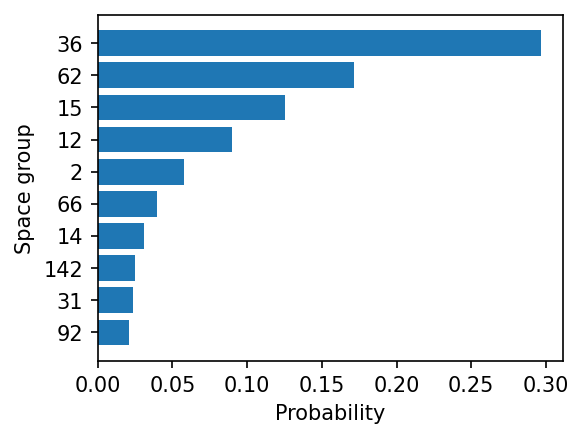

In [11]:
# preparing the data and prediction

def twotheta_to_q(two_theta, wavelength = 1.54184):
    q = 4*np.pi*(np.sin(np.deg2rad(two_theta/2)))/wavelength
    return q

input_xrd_2T =[13.188150, 16.194180, 16.761641, 18.773069, 19.228790, 23.013981, 25.197500, 25.270580, 26.545000, 26.581079]
# This XRD is taken from Table S3 in Park, W. B. et al. IUCrJ 4, 486–494 (2017).
# https://doi.org/10.1107/S205225251700714X
# The ground truth is orthorhombic system in the A21am (No. 36) space group.

input_xrd_Q = np.array(list(map(twotheta_to_q, input_xrd_2T))) # 2theta in CuKa -> Q

# prediction
classnames = ['Triclinic', 'Monoclinic', 'Orthorhombic', 'Tetragonal', 'Trigonal', 'Hexagonal', 'Cubic']
print('Predicted crystal system: ', classnames[exrt_crystal_system.predict(input_xrd_Q.reshape(1, -1))[0]])
print('Predicted space group: ', exrt_sgr.predict(input_xrd_Q.reshape(1, -1)))

# Checking predicted top 10 candidates and probability.

sg_pred_proba = exrt_sgr.predict_proba(input_xrd_Q.reshape(1, -1))
sgr_pred_top10_idx = np.argsort(-sg_pred_proba).squeeze()[:10]

plt.figure(figsize=(4,3), dpi=150)
plt.barh(sgr_nums[sgr_pred_top10_idx].astype(str)[::-1], 
         sg_pred_proba[0, sgr_pred_top10_idx][::-1])
plt.xlabel("Probability");
plt.ylabel("Space group");

## Testing with real experiment data
We used Sample1-3 from this round robin study: 
- Structure Determination by Powder Diffractometry Round Robin - 2  
Organized by : A. Le Bail and L.M.D Cranswick  
  - http://www.cristal.org/sdpdrr2/

Peak list in 2Theta:  [13.18815, 16.19418, 16.761641, 18.773069, 19.22879, 23.013981, 25.1975, 25.27058, 26.545, 26.581079]
Peak list in Q:  [0.84839556 0.94375999 0.96572735 1.10660815 1.21621764 1.26900741
 1.28544486 1.47190449 1.64301398 1.66871147]
Predicted crystal system:  Monoclinic
Predicted space group:  [14]


C:\Users\Matsunami\anaconda3\envs\ARIM-v2\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\Matsunami\anaconda3\envs\ARIM-v2\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\Matsunami\anaconda3\envs\ARIM-v2\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


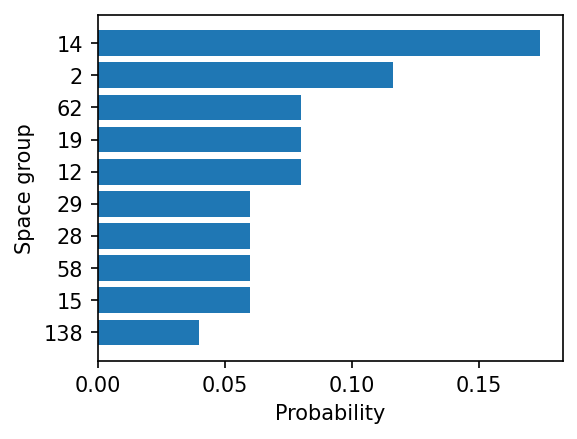

In [12]:
# Sample1

# def twotheta_to_q(two_theta, wavelength = 1.54184):
#     q = 4*np.pi*(np.sin(np.deg2rad(two_theta/2)))/wavelength
#     return q
# sample1 = pd.read_csv('/content/peaklist/powdx_p1.txt', sep=' ', skipinitialspace=True)
# sample1['2Theta'].astype('float')
# input_xrd_2T =sample1['2Theta'][:10].values
# input_xrd_Q = np.array(list(map(twotheta_to_q, sample1['2Theta'][:10]))) # 2theta in CuKa -> Q

# input_xrd_2T = np.array([11.95, 13.299, 13.61, 15.607, 17.164, 17.915, 18.149, 20.809, 23.26, 23.629])
input_xrd_Q = np.array([0.84839556, 0.94375999, 0.96572735, 1.10660815, 1.21621764, 1.26900741
, 1.28544486, 1.47190449, 1.64301398, 1.66871147])

print('Peak list in 2Theta: ', input_xrd_2T)
print('Peak list in Q: ', input_xrd_Q)

print('Predicted crystal system: ', classnames[exrt_crystal_system.predict(input_xrd_Q.reshape(1, -1))[0]])
print('Predicted space group: ', exrt_sgr.predict(input_xrd_Q.reshape(1, -1)))

# Checking predicted top 10 candidates and probability.
sg_pred_proba = exrt_sgr.predict_proba(input_xrd_Q.reshape(1, -1))
sgr_pred_top10_idx = np.argsort(-sg_pred_proba).squeeze()[:10]

plt.figure(figsize=(4,3), dpi=150)
plt.barh(sgr_nums[sgr_pred_top10_idx].astype(str)[::-1], 
         sg_pred_proba[0, sgr_pred_top10_idx][::-1])
plt.xlabel("Probability");
plt.ylabel("Space group");

Peak list in Q:  [0.58362101 0.65780434 0.74323434 0.83413412 0.9628833  1.01022197
 1.06783925 1.07113124 1.16328737 1.16712636]
Predicted crystal system:  Orthorhombic
Predicted space group:  [2]


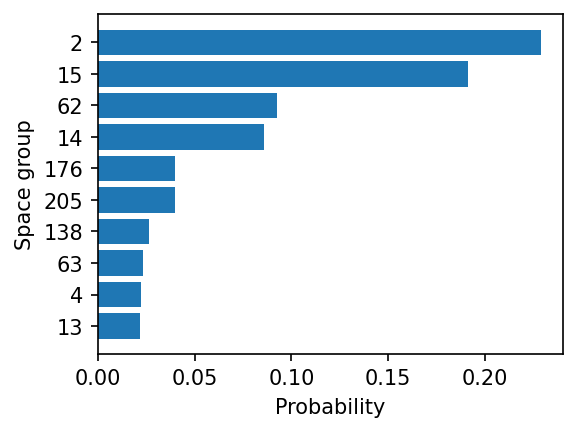

In [15]:
# Sample2

# def twotheta_to_q(two_theta, wavelength = 0.79764):
#     q = 4*np.pi*(np.sin(np.deg2rad(two_theta/2)))/wavelength
#     return q
# sample2 = pd.read_csv('/content/peaklist/powdx_p2.txt', sep=' ', skipinitialspace=True)
# sample2['2Theta'].astype('float')
# input_xrd_2T =sample2['2Theta'][:10].values
# input_xrd_Q = np.array(list(map(twotheta_to_q, sample2['2Theta'][:10]))) # 2theta -> Q

# input_xrd_2T = np.array([4.246, 4.786, 5.408, 6.07, , 7.008, 7.353, 7.773, 7.797, 8.469, 8.497])
input_xrd_Q = np.array([0.58362101, 0.65780434, 0.74323434, 0.83413412, 0.9628833, 1.01022197
, 1.06783925, 1.07113124, 1.16328737, 1.16712636])

# print('Peak list in 2Theta: ', input_xrd_2T)
print('Peak list in Q: ', input_xrd_Q)

print('Predicted crystal system: ', classnames[exrt_crystal_system.predict(input_xrd_Q.reshape(1, -1))[0]])
print('Predicted space group: ', exrt_sgr.predict(input_xrd_Q.reshape(1, -1)))

# Checking predicted top 10 candidates and probability.
sg_pred_proba = exrt_sgr.predict_proba(input_xrd_Q.reshape(1, -1))
sgr_pred_top10_idx = np.argsort(-sg_pred_proba).squeeze()[:10]

plt.figure(figsize=(4,3), dpi=150)
plt.barh(sgr_nums[sgr_pred_top10_idx].astype(str)[::-1], 
         sg_pred_proba[0, sgr_pred_top10_idx][::-1])
plt.xlabel("Probability");
plt.ylabel("Space group");

Peak list in 2Theta:  [ 3.419  4.839  5.929  7.656  8.39   9.061  9.69  10.28  11.369 11.877]
Peak list in Q:  [0.46998606 0.66508454 0.81477552 1.05179013 1.15245555 1.24443949
 1.33062717 1.41143455 1.56048596 1.62996852]
Predicted crystal system:  Orthorhombic
Predicted space group:  [12]


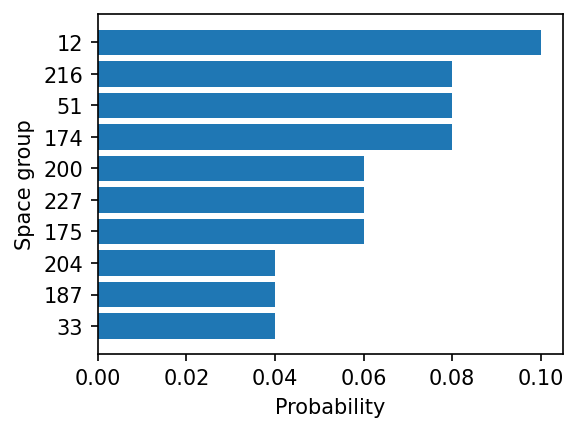

In [16]:
# Sample3

# def twotheta_to_q(two_theta, wavelength = 0.79764):
#     q = 4*np.pi*(np.sin(np.deg2rad(two_theta/2)))/wavelength
#     return q
# sample3 = pd.read_csv('/content/peaklist/powdx_p3.txt', sep=' ', skipinitialspace=True)
# sample3['2Theta'].astype('float')
# input_xrd_2T =sample3['2Theta'][:10].values
# input_xrd_Q = np.array(list(map(twotheta_to_q, sample3['2Theta'][:10]))) # 2theta -> Q

# input_xrd_2T = np.array([3.419, 4.839, 5.929, 7.656, 8.39,  9.061, 9.69, 10.28, 11.369, 11.877])
input_xrd_Q = np.array([0.46998606, 0.66508454, 0.81477552, 1.05179013, 1.15245555, 1.24443949
, 1.33062717, 1.41143455, 1.56048596, 1.62996852])

print('Peak list in 2Theta: ', input_xrd_2T)
print('Peak list in Q: ', input_xrd_Q)

print('Predicted crystal system: ', classnames[exrt_crystal_system.predict(input_xrd_Q.reshape(1, -1))[0]])
print('Predicted space group: ', exrt_sgr.predict(input_xrd_Q.reshape(1, -1)))

# Checking predicted top 10 candidates and probability.
sg_pred_proba = exrt_sgr.predict_proba(input_xrd_Q.reshape(1, -1))
sgr_pred_top10_idx = np.argsort(-sg_pred_proba).squeeze()[:10]

plt.figure(figsize=(4,3), dpi=150)
plt.barh(sgr_nums[sgr_pred_top10_idx].astype(str)[::-1], 
         sg_pred_proba[0, sgr_pred_top10_idx][::-1])
plt.xlabel("Probability");
plt.ylabel("Space group");